In [2]:
library(tidyverse)
library(stringr)

# install.packages('matrixStats', repos='http://cran.us.r-project.org')
library(matrixStats)
# install.packages('ggfortify', repos='http://cran.us.r-project.org')
library(ggfortify)
# install.packages('cluster', repos='http://cran.us.r-project.org')
library(cluster)

## load data

In [3]:
# alldat mito from A1
df_alldat_mito = read_csv("df_alldat_mito.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  Index = col_integer(),
  SegmentationXyPixelSize = col_double(),
  SegmentationZPixelSize = col_double(),
  Version = col_double(),
  imageXyPixelSize = col_double(),
  imageZPixelSize = col_double(),
  lightChannel = col_integer(),
  memChannel = col_integer(),
  nucChannel = col_integer(),
  outputThisCellIndex = col_integer(),
  structureChannel = col_integer(),
  timePoint = col_integer(),
  MitosisLabel = col_integer(),
  FinalScore = col_integer()
)
See spec(...) for full column specifications.


In [4]:
# df for translating dp to master inds
df_key = read_csv("df_key.csv")

Parsed with column specification:
cols(
  img_index = col_integer(),
  img_dp_index = col_integer(),
  img_phase = col_character(),
  img_label = col_character(),
  img_path = col_character()
)


In [5]:
# df_z from B0
df_z = read_csv('latent_space_embeddings.csv')
drop_cols = c("X1", "Unnamed: 0")
df_z = select(df_z,-one_of(drop_cols))
colnames(df_z)[1:2] = colnames(df_key)[c(3,2)]

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  phase = col_character(),
  dp_index = col_integer()
)
See spec(...) for full column specifications.
Warning message in one_of(drop_cols):
"Unknown variables: `Unnamed: 0`"

## join in mito and structure annotations

In [6]:
df_key %>% head

img_index,img_dp_index,img_phase,img_label,img_path
592,528,train,Tom20,20160705_I01_010.czi_5
7898,7086,train,Lamin B1,3500000896_100X_20170515_E05_P19.czi_2
5474,4911,train,Fibrillarin,3500000427_100X_20170120_F06_P33.czi_3
15427,1556,test,Tom20,3500001010_100X_20170626_2-Scene-02-P12-E05.czi_1
2005,193,test,Beta actin,20161216_C02_026.czi_11
15555,13990,train,Tom20,3500001003_100X_20170623_1-Scene-03-P3-F04.czi_1


In [7]:
df_key %>%
    inner_join(df_z) ->
    df_z_structure

df_alldat_mito %>%
    select(img_path,MitosisLabel) %>%
    inner_join(df_z_structure) ->
    df_z_mito_stuct

Joining, by = c("img_dp_index", "img_phase")
Joining, by = "img_path"


In [8]:
# write out latent embeddings df with mito annotations
df_z_mito_stuct %>% write_csv("latent_embeddings_mito_struct_annotations.csv")

In [9]:
df_z_mito_stuct %>% select(MitosisLabel) %>%
    filter(!is.na(MitosisLabel)) %>%
    dim

[1] 5827    1

In [43]:
df_z_mito_stuct$MitosisLabel = as.factor(df_z_mito_stuct$MitosisLabel)
df_z_mito_stuct$img_phase = as.factor(df_z_mito_stuct$img_phase)
df_z_mito_stuct$img_label = as.factor(df_z_mito_stuct$img_label)

## latent space plots

### reference channels

In [55]:
df_ref = df_z_mito_stuct[1:134]
df_ref$alpha = 0.01
df_ref[!is.na(df_ref$MitosisLabel),]$alpha = 1
df_ref[!is.na(df_ref$MitosisLabel) & df_ref$MitosisLabel == 0,]$alpha = 0.05
df_ref_dat = df_ref[7:134]

Saving 6.67 x 6.67 in image


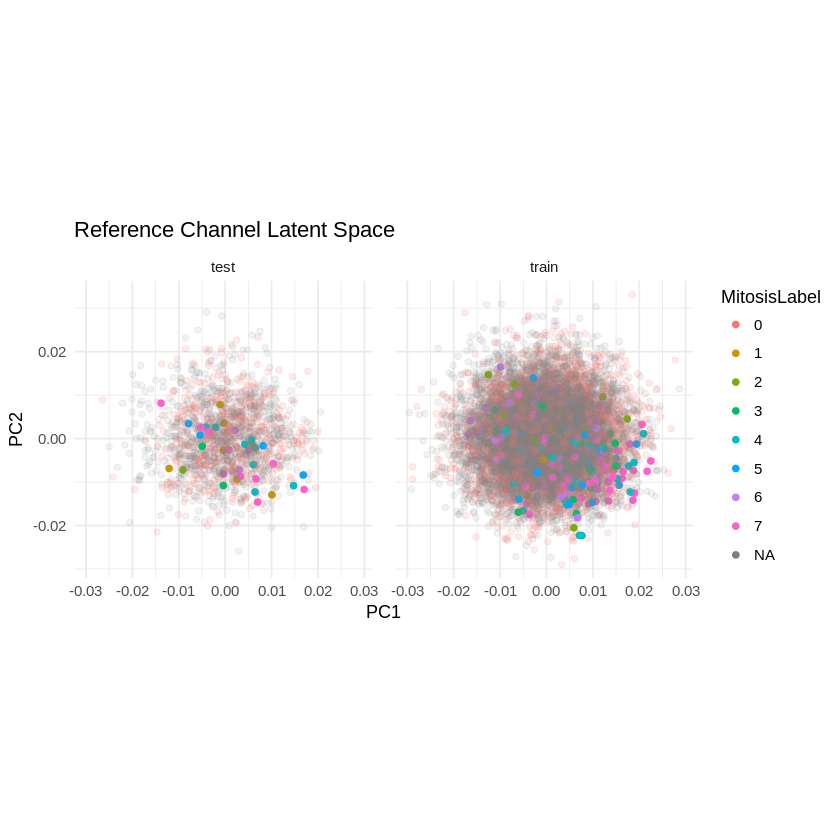

In [56]:
autoplot(prcomp(df_ref_dat),
         data=df_ref,
         colour='MitosisLabel',
         alpha='alpha') +
scale_alpha(guide = 'none') +
facet_wrap(~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Reference Channel Latent Space") ->
    p

ggsave(p, filename = "z_ref_by_mito.png", device="png", dpi = 600)
p

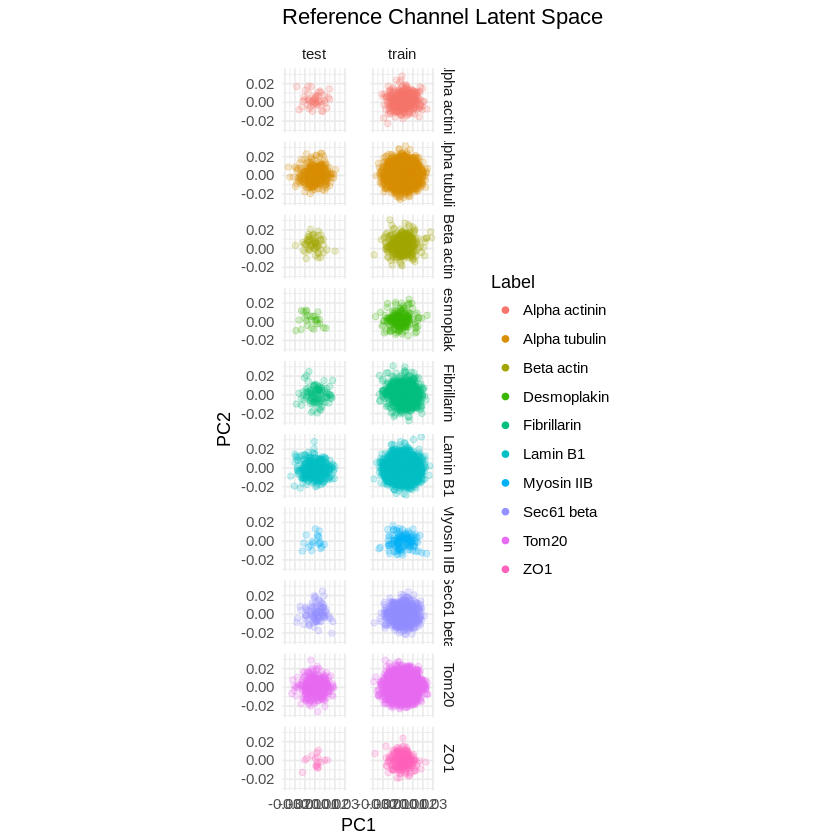

In [64]:
autoplot(prcomp(df_ref_dat),
         data=df_ref,
         colour='img_label',
         alpha=0.2) +
scale_alpha(guide = 'none') +
facet_grid(img_label~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
labs(title="Reference Channel Latent Space", color="Label") ->
    p

p

Saving 6.67 x 6.67 in image


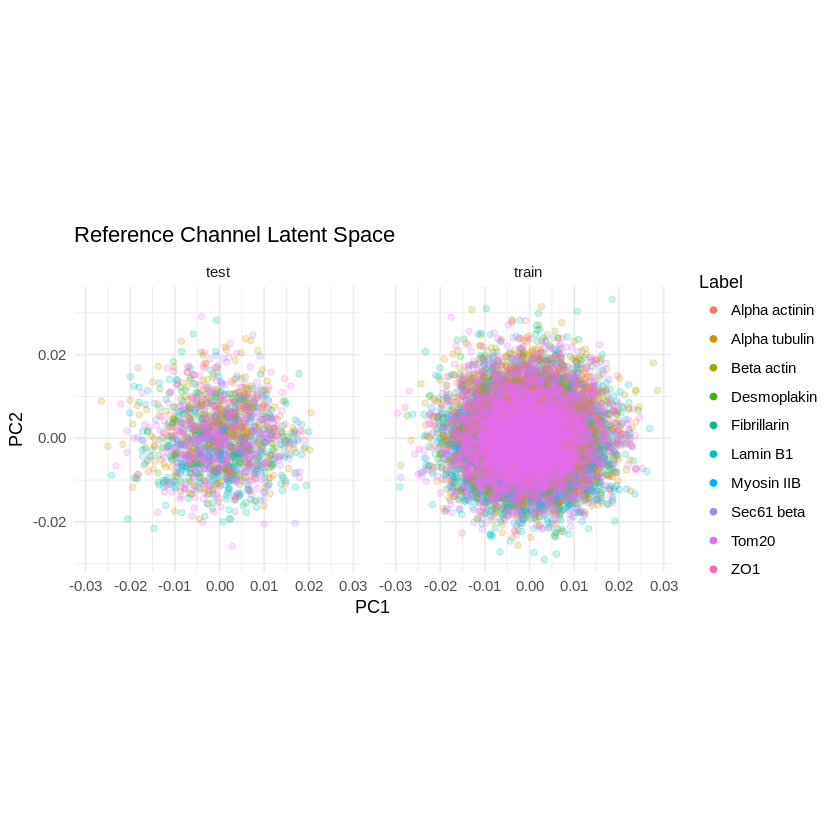

In [65]:
autoplot(prcomp(df_ref_dat),
         data=df_ref,
         colour='img_label',
         alpha=0.2) +
scale_alpha(guide = 'none') +
facet_wrap(~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
labs(title="Reference Channel Latent Space", color="Label") ->
    p

ggsave(p, filename = "z_ref_by_label.png", device="png", dpi = 600)
p

### structure channel

In [66]:
df_struct = df_z_mito_stuct[,c(1:6, 135:262)]
df_struct$alpha = 0.01
df_struct[!is.na(df_struct$MitosisLabel),]$alpha = 1
df_struct[!is.na(df_struct$MitosisLabel) & df_struct$MitosisLabel == 0,]$alpha = 0.05
df_struct_dat = df_struct[7:134]

Saving 6.67 x 6.67 in image


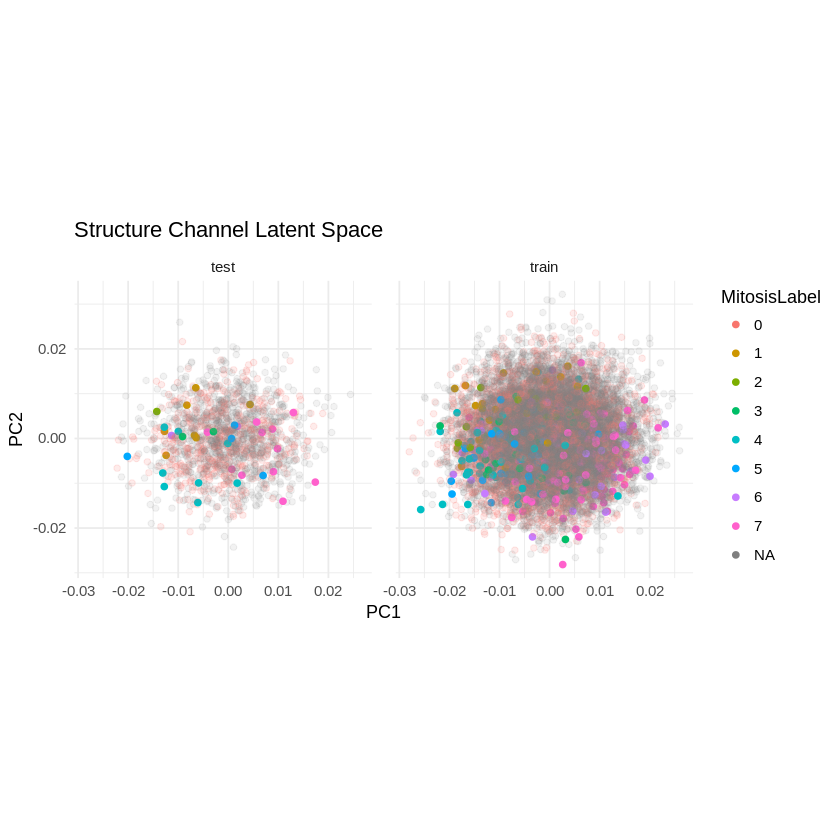

In [67]:
autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='MitosisLabel',
         alpha='alpha') +
scale_alpha(guide = 'none') +
facet_wrap(~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Structure Channel Latent Space") ->
    p

ggsave(p, filename = "z_struct_by_mito.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


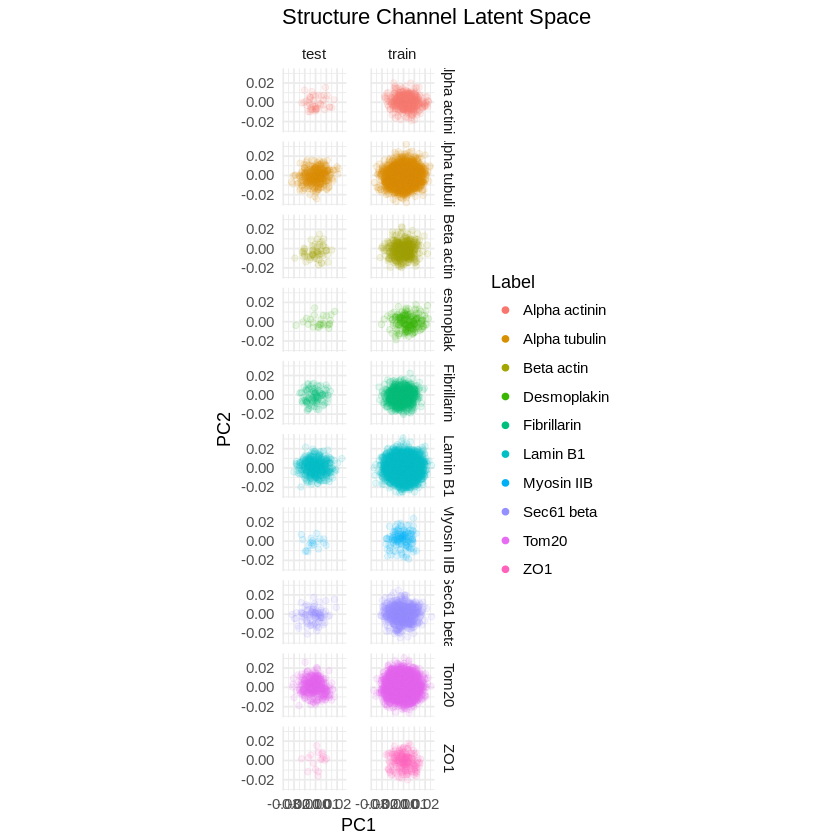

In [80]:

autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='img_label',
         alpha = 0.1,
         x = 1,
         y = 2) +
scale_alpha(guide = 'none') +
facet_grid(img_label~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
labs(title="Structure Channel Latent Space", color="Label") ->
    p

ggsave(p, filename = "z_struct_by_label.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


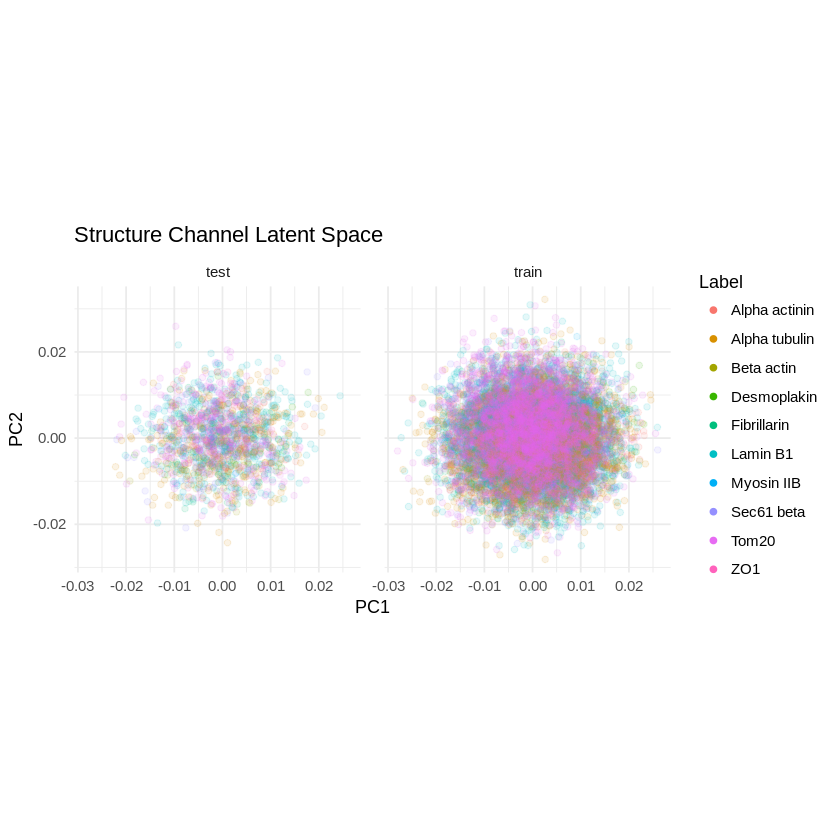

In [69]:
autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='img_label',
         alpha = 0.1,
         x = 1,
         y = 2) +
scale_alpha(guide = 'none') +
facet_wrap(~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
labs(title="Structure Channel Latent Space", color="Label") ->
    p

ggsave(p, filename = "z_struct_by_label.png", device="png", dpi = 600)
p

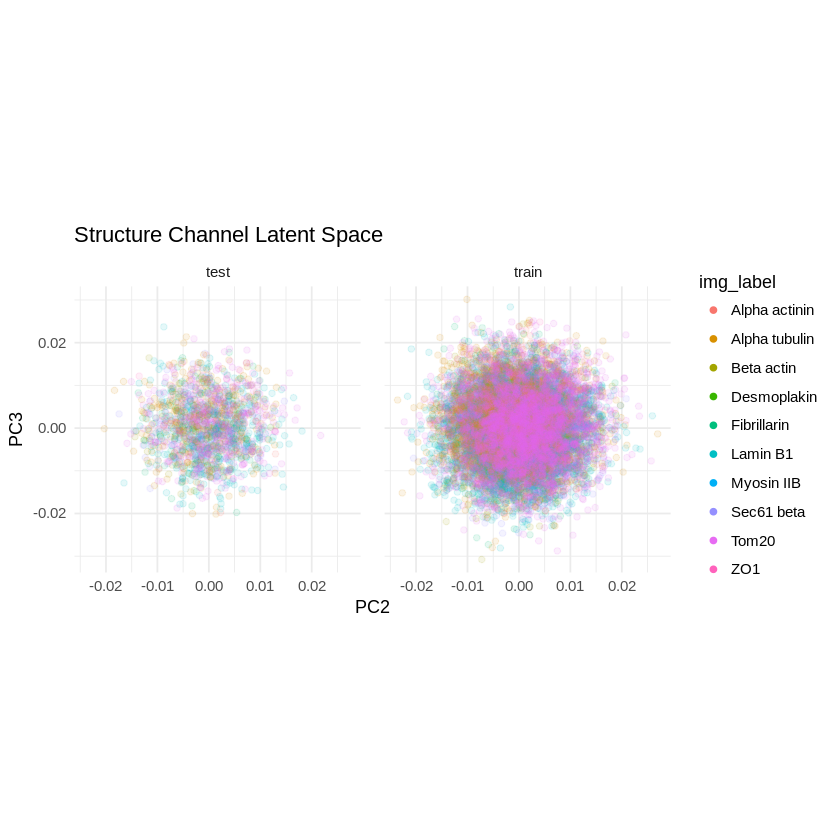

In [71]:
autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='img_label',
         alpha = 0.1,
         x = 2,
         y = 3) +
scale_alpha(guide = 'none') +
facet_wrap(~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Structure Channel Latent Space") +
guides(colour = guide_legend(override.aes = list(alpha = 1)))

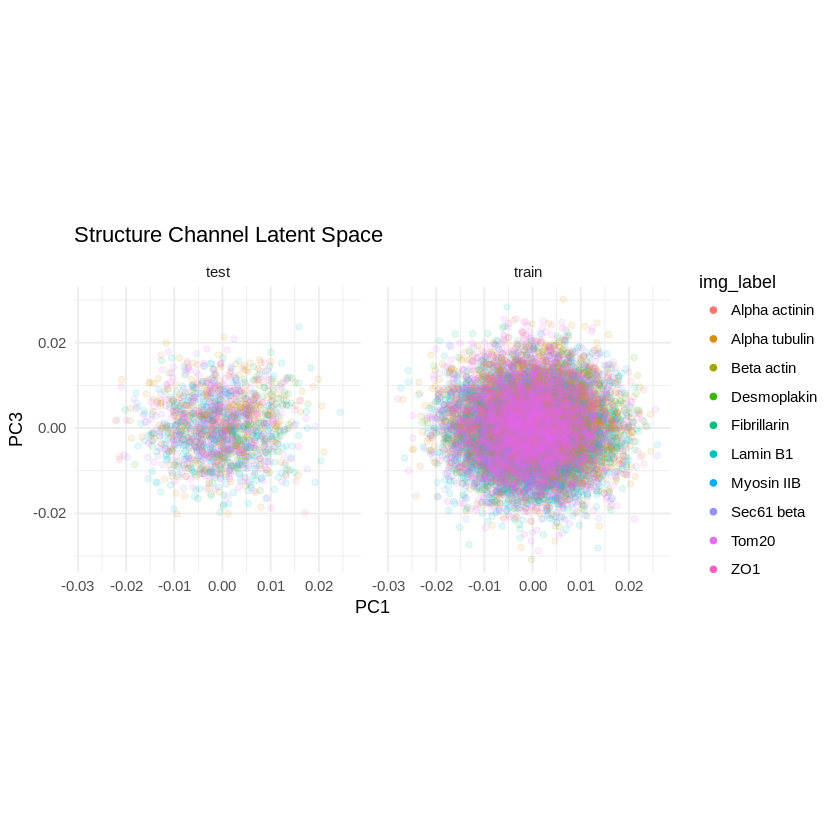

In [72]:
autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='img_label',
         alpha = 0.1,
         x = 1,
         y = 3) +
scale_alpha(guide = 'none') +
facet_wrap(~img_phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Structure Channel Latent Space") +
guides(colour = guide_legend(override.aes = list(alpha = 1)))

In [43]:
# find mediods for each mito class 

In [76]:
find_mediod <- function(df_in,
                        feature,
                        meta_data_cols=c('img_path', 'img_index', 'img_phase', 'img_dp_index', 'img_label', 'MitosisLabel'),
                        drop_cols=c("alpha")) {
    
    med_df = slice(df_in, 0)
    labs = df_in %>% select_(feature) %>% table %>% names
    
    for (lab in labs) {
        
        s = paste(feature, "==", sQuote(lab))
        df_in %>% filter_(s) ->
            df_tmp

        df_tmp %>%
            select(-one_of(meta_data_cols)) %>%
            pam(k=1) ->
            med

        med_df = rbind(med_df, df_tmp[med$id.med,])
    }
    med_df %>%
        select(-one_of(drop_cols)) ->
        med_df
    return(med_df)
}

In [77]:
find_mediod(df_ref,"MitosisLabel") %>% write_csv("z_ref_mito_mediods.csv")

In [78]:
find_mediod(df_struct,"MitosisLabel") %>% write_csv("z_struct_mito_mediods.csv")

In [79]:
find_mediod(df_struct,"label") %>% write_csv("z_struct_label_mediods.csv")

ERROR: Error in eval(expr, envir, enclos): object 'label' not found
